# Data Wrangling

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import env

In [2]:
database = 'titanic_db'
url = f'mysql+pymysql://{env.user}:{env.password}@{env.host}/{database}'
titanic = pd.read_sql('SELECT * FROM passengers', url)

database = 'mall_customers'
url = f'mysql+pymysql://{env.user}:{env.password}@{env.host}/{database}'
df = pd.read_sql('SELECT * FROM customers;', url)
df = df.set_index('customer_id')

In [3]:
print('--- Shape: {}'.format(df.shape))
print('--- Info')
df.info()
print('--- Descriptions')
print(df.describe(include='all'))

--- Shape: (200, 4)
--- Info
<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 1 to 200
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   gender          200 non-null    object
 1   age             200 non-null    int64 
 2   annual_income   200 non-null    int64 
 3   spending_score  200 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 7.8+ KB
--- Descriptions
        gender         age  annual_income  spending_score
count      200  200.000000     200.000000      200.000000
unique       2         NaN            NaN             NaN
top     Female         NaN            NaN             NaN
freq       112         NaN            NaN             NaN
mean       NaN   38.850000      60.560000       50.200000
std        NaN   13.969007      26.264721       25.823522
min        NaN   18.000000      15.000000        1.000000
25%        NaN   28.750000      41.500000       34.750000
50%        NaN

array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'annual_income'}>],
       [<AxesSubplot:title={'center':'spending_score'}>, <AxesSubplot:>]],
      dtype=object)

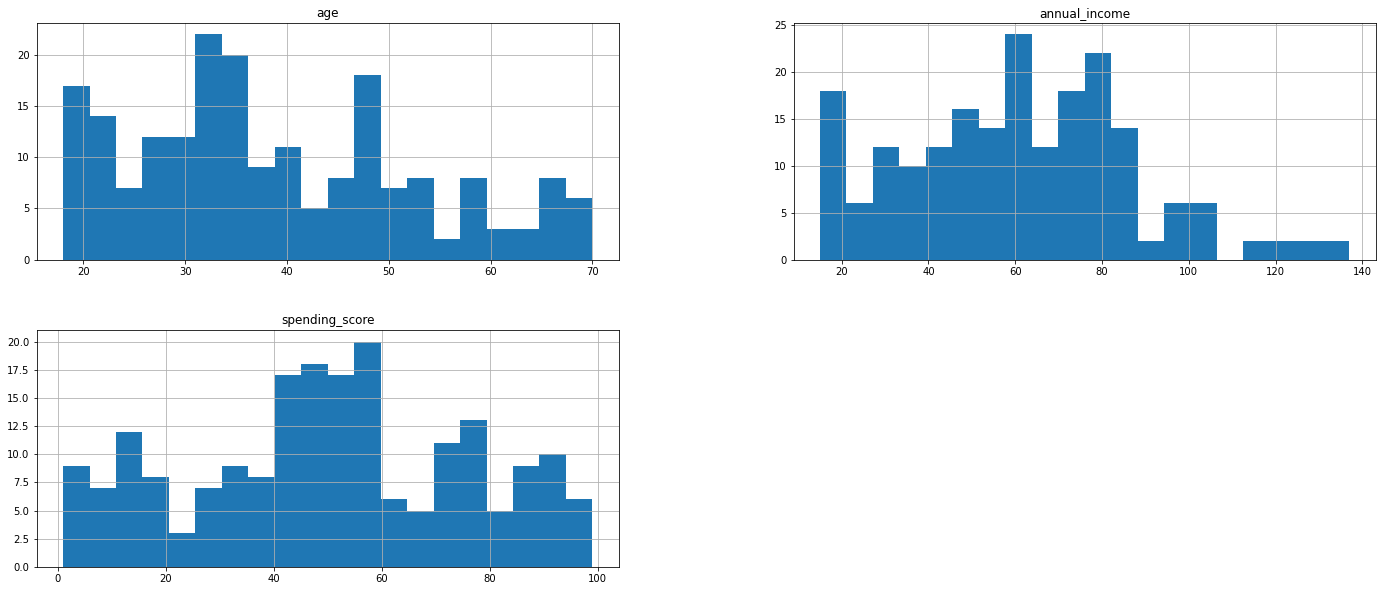

In [4]:
df.hist(figsize=(24, 10), bins=20)

## Investigate Nulls

In [12]:
titanic.isna().mean().rename('percent')

passenger_id    0.000000
survived        0.000000
pclass          0.000000
sex             0.000000
age             0.198653
sibsp           0.000000
parch           0.000000
fare            0.000000
embarked        0.002245
class           0.000000
deck            0.772166
embark_town     0.002245
alone           0.000000
Name: percent, dtype: float64

In [13]:
# Nulls by column
pd.DataFrame({
    'count': titanic.isna().sum(),
    'percent': titanic.isna().mean(),
})

,count,percent
passenger_id,0,0.000000
survived,0,0.000000
pclass,0,0.000000
sex,0,0.000000
age,177,0.198653
sibsp,0,0.000000
parch,0,0.000000
fare,0,0.000000
embarked,2,0.002245
class,0,0.000000


In [15]:
# Nulls by column
pd.concat([
    titanic.isna().sum().rename('count'),
    titanic.isna().mean().rename('percent')
], axis=1)

,count,percent
passenger_id,0,0.000000
survived,0,0.000000
pclass,0,0.000000
sex,0,0.000000
age,177,0.198653
sibsp,0,0.000000
parch,0,0.000000
fare,0,0.000000
embarked,2,0.002245
class,0,0.000000


In [27]:
# nulls by row
pd.concat([
    titanic.isna().sum(axis=1).rename('n_missing'),
    titanic.isna().mean(axis=1).rename('percent_missing'),
], axis=1).value_counts().sort_index()

n_missing  percent_missing
0          0.000000           182
1          0.076923           549
2          0.153846           160
dtype: int64

## Investigate Outliers

In [28]:
df.head()

,gender,age,annual_income,spending_score
customer_id,,,,
1,Male,19,15,39
2,Male,21,15,81
3,Female,20,16,6
4,Female,23,16,77
5,Female,31,17,40


In [30]:
q1 = df.annual_income.quantile(.25)
q3 = df.annual_income.quantile(.75)
q1, q3

(41.5, 78.0)

In [36]:
iqr = q3 - q1
# typical values for k are either 1.5 or 3; a greater value means less points will be considered outliers
k = 1.5
upper_bound = k * iqr + q3
df[df.annual_income > upper_bound]

,gender,age,annual_income,spending_score
customer_id,,,,
199,Male,32,137,18
200,Male,30,137,83


In [44]:
def replace_negative_with_zero(x):
    if x < 0:
        return 0
    else:
        return x

df['annual_income_outliers'] = df.annual_income - upper_bound
df.annual_income_outliers.apply(replace_negative_with_zero)

customer_id
1      0.00
2      0.00
3      0.00
4      0.00
5      0.00
       ... 
196    0.00
197    0.00
198    0.00
199    4.25
200    4.25
Name: annual_income_outliers, Length: 200, dtype: float64

In [46]:
df.annual_income_outliers

customer_id
1     -117.75
2     -117.75
3     -116.75
4     -116.75
5     -115.75
        ...  
196    -12.75
197     -6.75
198     -6.75
199      4.25
200      4.25
Name: annual_income_outliers, Length: 200, dtype: float64

In [45]:
def replace_negative_with_zero(x):
    return max([x, 0])

df['annual_income_outliers'] = df.annual_income - upper_bound
df.annual_income_outliers.apply(replace_negative_with_zero)

customer_id
1      0.00
2      0.00
3      0.00
4      0.00
5      0.00
       ... 
196    0.00
197    0.00
198    0.00
199    4.25
200    4.25
Name: annual_income_outliers, Length: 200, dtype: float64

In [47]:
def get_upper_outliers(s, k):
    '''
    Given a series and a cutoff value, k, returns the upper outliers for the
    series.
    
    The values returned will be either 0 (if the point is not an outlier), or a
    number that indicates how far away from the upper bound the observation is.
    '''
    q1, q3 = s.quantile([.25, .75])
    iqr = q3 - q1
    upper_bound = q3 + k * iqr
    return s.apply(lambda x: max([x - upper_bound, 0]))

def add_upper_outlier_columns(df, k):
    '''
    Add a column with the suffix _outliers for all the numeric columns
    in the given dataframe.
    '''
    # outlier_cols = {col + '_outliers': get_upper_outliers(df[col], k)
    #                 for col in df.select_dtypes('number')}
    # return df.assign(**outlier_cols)
    
    for col in df.select_dtypes('number'):
        df[col + '_outliers'] = get_upper_outliers(df[col], k)
        
    return df

add_upper_outlier_columns(df, k=1.5)

df.head()

,gender,age,annual_income,spending_score,annual_income_outliers,age_outliers,spending_score_outliers,annual_income_outliers_outliers
customer_id,,,,,,,,
1,Male,19,15,39,0.0,0,0,0.0
2,Male,21,15,81,0.0,0,0,0.0
3,Female,20,16,6,0.0,0,0,0.0
4,Female,23,16,77,0.0,0,0,0.0
5,Female,31,17,40,0.0,0,0,0.0


In [48]:
outlier_cols = [col for col in df if col.endswith('_outliers')]
for col in outlier_cols:
    print('~~~\n' + col)
    data = df[col][df[col] > 0]
    print(data.describe())

~~~
annual_income_outliers
count    2.00
mean     4.25
std      0.00
min      4.25
25%      4.25
50%      4.25
75%      4.25
max      4.25
Name: annual_income_outliers, dtype: float64
~~~
age_outliers
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: age_outliers, dtype: float64
~~~
spending_score_outliers
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: spending_score_outliers, dtype: float64
~~~
annual_income_outliers_outliers
count    2.00
mean     4.25
std      0.00
min      4.25
25%      4.25
50%      4.25
75%      4.25
max      4.25
Name: annual_income_outliers_outliers, dtype: float64
